In [1]:
import os
import time
import random
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

from PIL import Image
import numpy as np

import matplotlib.pyplot as plt

from model.HiIR import HiIR
import piq

In [2]:
# super_resolution_manga_full_v3.py

# -----------------------------
# 1. DATASET: MangaRestorationDataset
# -----------------------------
class MangaRestorationDataset(Dataset):
    """
    Dataset especializado para manga con:
      - Full B/W → 1 sample (grayscale patch)
      - Full color → 3 samples (one per channel, each replicated to 3-ch)
      - Hybrid    → 1 B/W sample + 3 color-channel samples
    """
    def __init__(self,
                 manga_root_dir: str,
                 patch_size: int = 64,
                 augmentation_factor: int = 1):
        super().__init__()
        self.patch_size = patch_size
        self.aug_factor = augmentation_factor

        # Collect all images
        self.image_paths = sorted(Path(manga_root_dir).rglob('*.png')) + \
                           sorted(Path(manga_root_dir).rglob('*.jpg'))
        if not self.image_paths:
            raise RuntimeError(f"[ERROR Dataset] No images in {manga_root_dir!r}")

        # Precompute “samples”: one entry per output image
        self.samples = []
        for p in self.image_paths:
            img = Image.open(p).convert('RGB')
            arr = np.array(img)
            h, w, _ = arr.shape
            half = w // 2

            # helper to test grayscale
            def is_gray(region):
                R, G, B = region[...,0], region[...,1], region[...,2]
                return np.all(R == G) and np.all(G == B)

            left, right = arr[:, :half], arr[:, half:]
            left_gray, right_gray = is_gray(left), is_gray(right)

            if left_gray and right_gray:
                # full B/W → one sample
                self.samples.append({'path': p, 'mode': 'full_bw'})
            elif (not left_gray) and (not right_gray):
                # full color → three channel-splits
                for c in range(3):
                    self.samples.append({'path': p, 'mode': 'full_color', 'ch': c})
            else:
                # hybrid:
                # figure out which half is colored
                if left_gray:
                    gray_half, color_half = 'left', 'right'
                else:
                    gray_half, color_half = 'right', 'left'
                # 1) B/W sample: mask away the color half
                self.samples.append({
                    'path': p,
                    'mode': 'hybrid_bw',
                    'color_half': color_half
                })
                # 2) 3 color-channel samples from the colored half
                for c in range(3):
                    self.samples.append({
                        'path': p,
                        'mode': 'hybrid_color',
                        'color_half': color_half,
                        'ch': c
                    })

    def __len__(self):
        return len(self.samples) * self.aug_factor

    def __getitem__(self, idx):
        base_idx = idx // self.aug_factor
        spec = self.samples[base_idx]
        img = Image.open(spec['path']).convert('RGB')
        arr = np.array(img)
        h, w, _ = arr.shape
        half = w // 2

        # Build the “HR” image according to mode:
        if spec['mode'] == 'full_bw':
            hr_arr = arr  # already grayscale in channels

        elif spec['mode'] == 'full_color':
            c = spec['ch']
            chan = arr[...,c]
            hr_arr = np.stack([chan]*3, axis=-1)

        elif spec['mode'] == 'hybrid_bw':
            # zero-out the colored half
            hr_arr = arr.copy()
            if spec['color_half'] == 'left':
                hr_arr[:, :half] = 0
            else:
                hr_arr[:, half:] = 0

        elif spec['mode'] == 'hybrid_color':
            # isolate the colored half, then channel-split
            hr_arr = np.zeros_like(arr)
            if spec['color_half'] == 'left':
                hr_arr[:, :half] = arr[:, :half]
            else:
                hr_arr[:, half:] = arr[:, half:]
            c = spec['ch']
            chan = hr_arr[...,c]
            hr_arr = np.stack([chan]*3, axis=-1)

        else:
            raise RuntimeError(f"Unknown mode {spec['mode']}")

        # now hr_arr is H×W×3 uint8; randomly crop a patch:
        img_hr = Image.fromarray(hr_arr.astype(np.uint8))
        if img_hr.width < self.patch_size or img_hr.height < self.patch_size:
            img_hr = img_hr.resize((self.patch_size, self.patch_size), Image.BICUBIC)

        x = random.randint(0, img_hr.width - self.patch_size)
        y = random.randint(0, img_hr.height - self.patch_size)
        img_hr = img_hr.crop((x, y, x + self.patch_size, y + self.patch_size))

        # bicubic ↓4
        lr_size = (self.patch_size // 4, self.patch_size // 4)
        img_lr = img_hr.resize(lr_size, Image.BICUBIC)

        # to Tensors in [0,1]
        hr_np = np.array(img_hr).astype(np.float32) / 255.0
        lr_np = np.array(img_lr).astype(np.float32) / 255.0
        hr_t = torch.from_numpy(hr_np.transpose(2,0,1))
        lr_t = torch.from_numpy(lr_np.transpose(2,0,1))

        return {
            'degraded': lr_t,
            'clean':    hr_t,
            'mode':     spec['mode'],
            'manga_name': spec['path'].stem
        }


# -----------------------------
# 2. MÉTRICAS: PSNR y SSIM (soporte batch)
# -----------------------------
def compute_metrics_tensor(sr: torch.Tensor, hr: torch.Tensor):
    psnr = piq.psnr(sr, hr, data_range=1.0, reduction='mean').item()
    ssim = piq.ssim(sr, hr, data_range=1.0, reduction='mean').item()
    return psnr, ssim

# -----------------------------
# 3. TRAINER: MangaTrainer
# -----------------------------
class MangaTrainer:
    """
    Trainer para dataset de manga con modelo HiIR:
    - Entrenamiento, validación, checkpoints y curvas de pérdida.
    """
    def __init__(self, model, train_dataset, val_dataset=None, device='cuda'):
        self.device = device if torch.cuda.is_available() else 'cpu'
        self.model = model.to(self.device)
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset

        # AdamW
        self.optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=2e-4,
            betas=(0.9, 0.999),
            weight_decay=1e-2
        )
        # Scheduler: warm-up 50k, luego decaimiento 0.5 cada 200k
        self.total_steps = 0
        self.warmup_steps = 50_000
        self.decay_step = 200_000
        self.scheduler = torch.optim.lr_scheduler.LambdaLR(
            self.optimizer,
            lr_lambda=self._lr_lambda
        )
        self.criterion = nn.L1Loss()

    def _lr_lambda(self, step):
        if step < self.warmup_steps:
            return float(step) / float(max(1, self.warmup_steps))
        else:
            num_decays = (step - self.warmup_steps) // self.decay_step
            return 0.5 ** num_decays

    def train_epoch(self, dataloader):
        self.model.train()
        running_loss = 0.0
        running_psnr = 0.0
        running_ssim = 0.0
        cnt = 0

        for batch in dataloader:
            lr = batch['degraded'].to(self.device)   # (B,3,p/4,p/4)
            hr = batch['clean'].to(self.device)      # (B,3,p,p)

            sr = self.model(lr)                      # (B,3,p,p)
            loss = self.criterion(sr, hr)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            self.scheduler.step()
            self.total_steps += 1

            running_loss += loss.item()
            with torch.no_grad():
                psnr_batch, ssim_batch = compute_metrics_tensor(sr, hr)
            running_psnr += psnr_batch
            running_ssim += ssim_batch
            cnt += 1

        return running_loss / cnt, running_psnr / cnt, running_ssim / cnt

    def validate(self, dataloader, max_batches=5):
        self.model.eval()
        val_loss = 0.0
        val_psnr = 0.0
        val_ssim = 0.0
        cnt = 0
        with torch.no_grad():
            for i, batch in enumerate(dataloader):
                if i >= max_batches:
                    break
                lr = batch['degraded'].to(self.device)
                hr = batch['clean'].to(self.device)
                sr = self.model(lr)
                loss = self.criterion(sr, hr)
                val_loss += loss.item()
                psnr_batch, ssim_batch = compute_metrics_tensor(sr, hr)
                val_psnr += psnr_batch
                val_ssim += ssim_batch
                cnt += 1
        if cnt == 0:
            return None, None, None
        return val_loss / cnt, val_psnr / cnt, val_ssim / cnt

    def train(self,
              num_epochs: int,
              batch_size: int,
              num_workers: int,
              save_path: str):
        """
        Entrena el modelo num_epochs épocas.
        Guarda checkpoints cada 10 épocas.
        Dibuja curva de pérdida al final.
        """
        train_loader = DataLoader(
            self.train_dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=0,        # 0 para ver errores en hilo principal
            pin_memory=True,
            drop_last=True
        )
        if self.val_dataset is not None:
            val_loader = DataLoader(
                self.val_dataset,
                batch_size=batch_size,
                shuffle=False,
                num_workers=0,
                pin_memory=True
            )
        else:
            val_loader = None

        train_losses, val_losses = [], []
        train_psnrs, val_psnrs = [], []
        train_ssims, val_ssims = [], []

        for epoch in range(1, num_epochs + 1):
            start_time = time.time()
            train_loss, train_psnr, train_ssim = self.train_epoch(train_loader)
            train_losses.append(train_loss)
            train_psnrs.append(train_psnr)
            train_ssims.append(train_ssim)

            if val_loader is not None:
                val_loss, val_psnr, val_ssim = self.validate(val_loader)
                val_losses.append(val_loss)
                val_psnrs.append(val_psnr)
                val_ssims.append(val_ssim)
                print(f"Época [{epoch}/{num_epochs}]  "
                      f"Train Loss: {train_loss:.6f}  "
                      f"Train PSNR: {train_psnr:.4f}  "
                      f"Train SSIM: {train_ssim:.4f}  "
                      f"Val Loss: {val_loss:.6f}  "
                      f"Val PSNR: {val_psnr:.4f}  "
                      f"Val SSIM: {val_ssim:.4f}  "
                      f"Tiempo: {time.time() - start_time:.1f}s")
            else:
                print(f"Época [{epoch}/{num_epochs}]  "
                      f"Train Loss: {train_loss:.6f}  "
                      f"Train PSNR: {train_psnr:.4f}  "
                      f"Train SSIM: {train_ssim:.4f}  "
                      f"Tiempo: {time.time() - start_time:.1f}s")

            if epoch % 10 == 0:
                ckpt_path = f"{save_path}_ep{epoch}.pth"
                torch.save(self.model.state_dict(), ckpt_path)
                print(f"🔖 Checkpoint guardado en: {ckpt_path}")

        torch.save(self.model.state_dict(),f"{save_path}_final.pth")
        print(f"✅ Modelo final guardado en: {save_path}")

        # Curva de pérdida
        plt.figure(figsize=(8, 6))
        plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
        if val_losses:
            plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
        plt.xlabel('Época')
        plt.ylabel('Loss (L1)')
        plt.title('Curva de Pérdida')
        plt.legend()
        plt.tight_layout()
        plt.savefig('training_curves.png', dpi=300)
        plt.close()
        print("📈 Curvas de pérdida guardadas en 'training_curves.png'")

        return train_losses, val_losses


# -----------------------------
# 8. VISUALIZACIÓN DE PÁGINA COMPLETA
# -----------------------------

def visualize_full_page(sr_model: nn.Module,
                        dataset: MangaRestorationDataset,
                        device: str,
                        patch_size: int,
                        window_size: int,
                        image_id: int):
    """
    Muestra una página completa tras simular:
      - full B/W   → nada que hacer
      - full color → split en 3 B/W + fuse
      - hybrid     → split en B/W half + 3 B/W color-half + fuse
    Luego ↓4 bicúbico, SR con el modelo, calcula PSNR/SSIM y muestra LR, SR y HR.
    """
    sr_model.eval()

    # — helper: detect grayscale on a region —
    def is_gray(arr: np.ndarray):
        R, G, B = arr[...,0], arr[...,1], arr[...,2]
        return np.all(R == G) and np.all(G == B)

    # 1) cargar full HR
    img_path = dataset.image_paths[image_id]
    pil = Image.open(img_path).convert('RGB')
    arr = np.array(pil)                        # H×W×3 uint8
    H, W, _ = arr.shape
    half = W // 2

    # 2) decidir caso
    left, right = arr[:, :half], arr[:, half:]
    left_gray, right_gray = is_gray(left), is_gray(right)

    if left_gray and right_gray:
        # — full B/W —
        hr_arr = arr.copy()

    elif (not left_gray) and (not right_gray):
        # — full color: split into 3 B/W then fuse —
        bw_splits = []
        for c in range(3):
            chan = arr[..., c]                     # H×W
            bw = np.stack([chan]*3, axis=-1)       # H×W×3
            bw_splits.append(bw)
        # fuse back: take channel-0 of each split as R,G,B
        channels = [bw[..., 0] for bw in bw_splits]
        hr_arr = np.stack(channels, axis=-1)      # H×W×3

    else:
        # — hybrid —
        # 2a) B/W half
        gray_arr = arr.copy()
        if left_gray:
            # color is on right
            gray_arr[:, half:] = 0
            color_half = 'right'
        else:
            gray_arr[:, :half] = 0
            color_half = 'left'

        # 2b) color half isolation
        color_arr = np.zeros_like(arr)
        if color_half == 'left':
            color_arr[:, :half] = arr[:, :half]
        else:
            color_arr[:, half:] = arr[:, half:]

        # split color half into 3 B/W
        bw_color = []
        for c in range(3):
            chan = color_arr[..., c]
            bw = np.stack([chan]*3, axis=-1)
            bw_color.append(bw)
        # fuse color-half
        color_fused = np.stack([bw[..., 0] for bw in bw_color], axis=-1)

        # final fused HR
        hr_arr = gray_arr + color_fused

    # 3) ahora hr_arr es H×W×3 float in [0..255]
    hr_arr = np.clip(hr_arr.astype(np.float32) / 255.0, 0, 1)

    # 4) alinear a múltiplo de (scale * patch_size * window_size)
    scale = 4
    P = patch_size * window_size
    align = scale * P
    new_W = W - (W % align)
    new_H = H - (H % align)
    if new_W != W or new_H != H:
        left_crop = (W - new_W)//2
        top_crop  = (H - new_H)//2
        hr_arr = hr_arr[top_crop:top_crop+new_H,
                        left_crop:left_crop+new_W]

    Hc, Wc, _ = hr_arr.shape

    # 5) degradación bicúbica ↓4
    img_hr = Image.fromarray((hr_arr*255).astype(np.uint8))
    lr_size = (Wc//4, Hc//4)
    img_lr = img_hr.resize(lr_size, resample=Image.BICUBIC)
    lr_arr = np.array(img_lr).astype(np.float32)/255.0

    # 6) tensores
    hr_t = torch.from_numpy(hr_arr.transpose(2,0,1)).unsqueeze(0).to(device)
    lr_t = torch.from_numpy(lr_arr.transpose(2,0,1)).unsqueeze(0).to(device)

    # 7) inferencia SR
    with torch.no_grad():
        sr_t = sr_model(lr_t)

    # 8) métricas
    psnr_full, ssim_full = compute_metrics_tensor(sr_t, hr_t)

    # 9) para mostrar
    lr_show = lr_t.squeeze(0).cpu().numpy().transpose(1,2,0)
    sr_show = sr_t.squeeze(0).cpu().numpy().transpose(1,2,0)

    fig, axs = plt.subplots(1,3,figsize=(18,8))
    axs[0].imshow(np.clip(lr_show,0,1))
    axs[0].set_title(f"LR ({lr_size[0]}×{lr_size[1]})")
    axs[0].axis("off")

    axs[1].imshow(np.clip(sr_show,0,1))
    axs[1].set_title(f"SR ({Wc}×{Hc})\nPSNR:{psnr_full:.2f}dB   SSIM:{ssim_full:.4f}")
    axs[1].axis("off")

    axs[2].imshow(np.clip(hr_arr,0,1))
    axs[2].set_title(f"HR ({Wc}×{Hc})")
    axs[2].axis("off")

    plt.tight_layout()
    plt.show()


Device: cuda
Cargando dataset
✅ Dataset cargado: total=11262, train=9009, val=2253 , Tiempo usado: 204.8s
🖼️  Modelo HiIR instanciado. Parámetros totales: 2,745,699
🚀 Iniciando entrenamiento...
Época [1/120]  Train Loss: 0.423058  Train PSNR: 6.9488  Train SSIM: 0.0253  Val Loss: 0.425147  Val PSNR: 6.9025  Val SSIM: 0.0256  Tiempo: 223.2s
Época [2/120]  Train Loss: 0.420670  Train PSNR: 6.9972  Train SSIM: 0.0256  Val Loss: 0.420571  Val PSNR: 6.9848  Val SSIM: 0.0261  Tiempo: 221.4s
Época [3/120]  Train Loss: 0.416874  Train PSNR: 7.0682  Train SSIM: 0.0264  Val Loss: 0.413972  Val PSNR: 7.1385  Val SSIM: 0.0277  Tiempo: 221.2s
Época [4/120]  Train Loss: 0.410175  Train PSNR: 7.2140  Train SSIM: 0.0276  Val Loss: 0.402922  Val PSNR: 7.3441  Val SSIM: 0.0278  Tiempo: 222.1s
Época [5/120]  Train Loss: 0.400507  Train PSNR: 7.4106  Train SSIM: 0.0295  Val Loss: 0.393775  Val PSNR: 7.5522  Val SSIM: 0.0303  Tiempo: 222.4s
Época [6/120]  Train Loss: 0.391150  Train PSNR: 7.6235  Train SSI

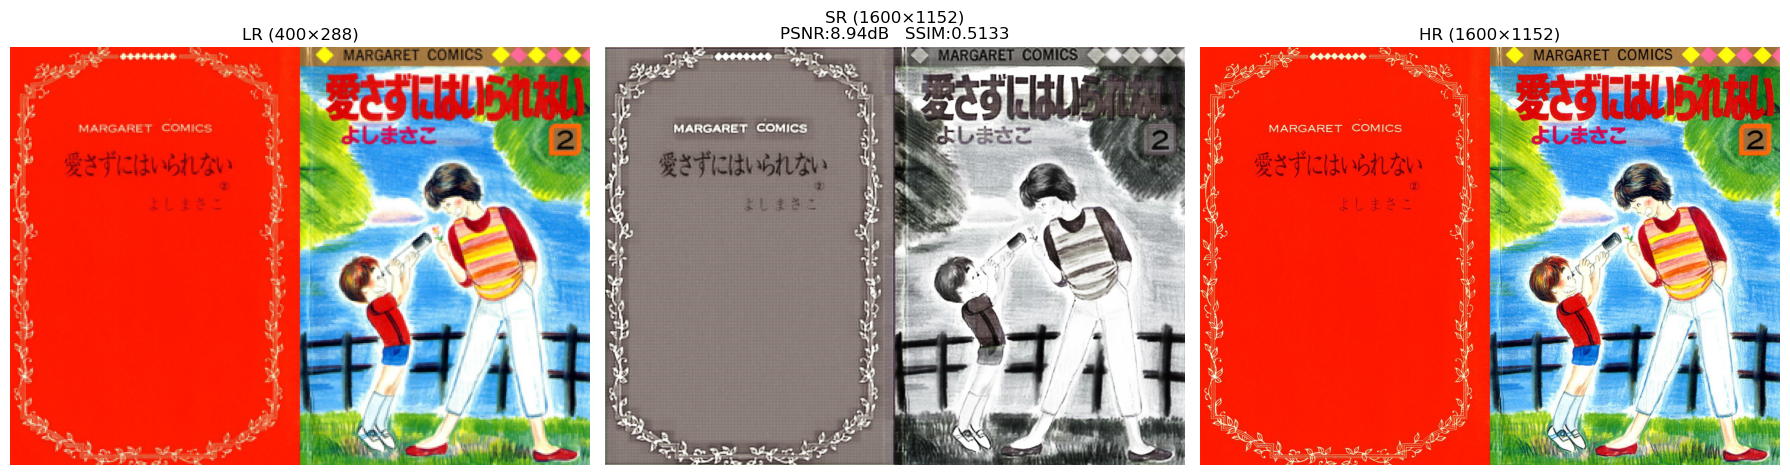

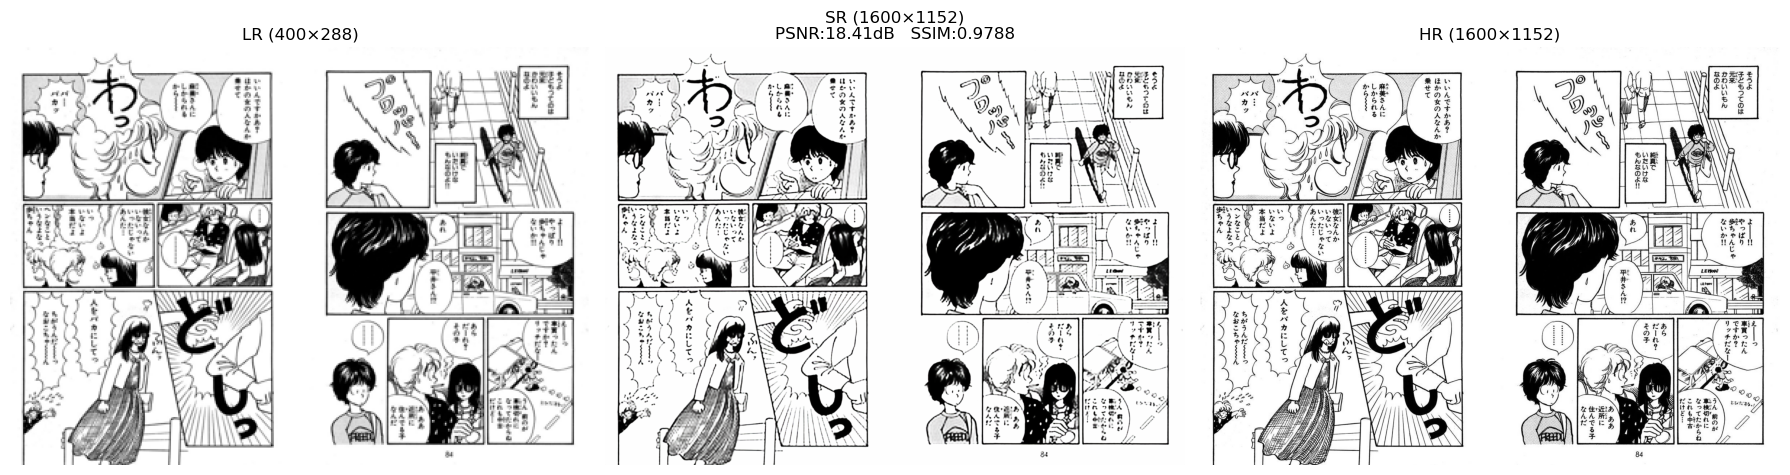

In [3]:
# -----------------------------
# 9. MAIN: Configuración, Entrenamiento y Visualización
# -----------------------------
def main():
    # Directorio raíz con imágenes de manga (subcarpetas anidadas)
    manga_root = r"G:\MaestriaInformatica\Tecnicas avanzadas\Trabajo_ grupal\Manga109_released_2023_12_07\images"

    # Parámetros de dataset
    patch_size = 64
    aug_factor = 1
    train_split = 0.8

    # Parámetros de entrenamiento
    batch_size = 256
    num_workers = 0   # usar 0 para debugging
    num_epochs = 120
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Device: {device}")
    # 9.1. Construir dataset y particionar
    print("Cargando dataset")
    start_dtst = time.time()
    try:
        full_dataset = MangaRestorationDataset(
            manga_root_dir=manga_root,
            patch_size=patch_size,
            augmentation_factor=aug_factor
        )
    except RuntimeError as e:
        print(f"[ERROR al crear dataset] {e}")
        return

    total_len = len(full_dataset)
    train_len = int(train_split * total_len)
    val_len = total_len - train_len
    train_ds, val_ds = random_split(
        full_dataset,
        [train_len, val_len],
        generator=torch.Generator().manual_seed(42)
    )
    print(f"✅ Dataset cargado: total={total_len}, train={train_len}, val={val_len} , Tiempo usado: {time.time() - start_dtst:.1f}s")

    # 9.2. Instanciar modelo HiIR
    model_args = dict(
        img_size=patch_size,
        in_chans=3,
        out_chans=3,
        embed_dim=96,
        depths=8,
        num_heads=6,
        patch_size=8,
        window_size=2,
        mlp_ratio=4.0,
        qkv_bias=True,
        dropout=0.0
    )
    
    model = HiIR(**model_args).to(device)

    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"🖼️  Modelo HiIR instanciado. Parámetros totales: {total_params:,}")

    # 9.3. Crear entrenador
    trainer = MangaTrainer(
        model=model,
        train_dataset=train_ds,
        val_dataset=val_ds,
        device=device
    )

    # 9.4. Entrenar
    print("🚀 Iniciando entrenamiento...")
    save_path = r"G:\MaestriaInformatica\Tecnicas avanzadas\Trabajo_ grupal\Models_v2\hiir_manga"
    trainer.train(
        num_epochs=num_epochs,
        batch_size=batch_size,
        num_workers=num_workers,
        save_path=save_path
    )

    # 9.5. Visualizar página completa
    print("\n🔍 Mostrando página completa de validación:")
    visualize_full_page(model, full_dataset, device, patch_size=model_args["patch_size"],window_size=model_args["window_size"],image_id=0)
    visualize_full_page(model, full_dataset, device, patch_size=model_args["patch_size"],window_size=model_args["window_size"],image_id=42)
    
if __name__ == "__main__":
    main()

In [7]:
import os
from pathlib import Path
import torch
import numpy as np
from PIL import Image
import pandas as pd
import piq
from model.HiIR import HiIR

# ==== Configuration ====
dataset_dir = r"G:\MaestriaInformatica\Tecnicas avanzadas\Trabajo_ grupal\Manga109_released_2023_12_07\images"
model_path = r"G:\MaestriaInformatica\Tecnicas avanzadas\Trabajo_ grupal\Models_v2\hiir_manga_final.pth"
output_csv = "sr_evaluation_results.csv"
device = "cuda" if torch.cuda.is_available() else "cpu"

# List of image IDs to export PNGs for
image_ids_to_export = [0, 42, 123]  # <-- define your IDs here

# Output folders for PNGs
output_base = Path("sr_outputs")
hr_folder = output_base / "HR"
lr_folder = output_base / "LR"
sr_folder = output_base / "SR"
for folder in (hr_folder, lr_folder, sr_folder):
    folder.mkdir(parents=True, exist_ok=True)

model_args = dict(
    img_size=64,
    in_chans=3,
    out_chans=3,
    embed_dim=96,
    depths=8,
    num_heads=6,
    patch_size=8,
    window_size=2,
    mlp_ratio=4.0,
    qkv_bias=True,
    dropout=0.0
)

# Compute alignment multiple
scale = 4
P = model_args["patch_size"] * model_args["window_size"]
align = scale * P  # e.g. 4*(8*2)=64

# ==== Load model ====
model = HiIR(**model_args).to(device)
state = torch.load(model_path, map_location=device)
model.load_state_dict(state)
model.eval()

# ==== Helper functions ====
def is_gray(arr: np.ndarray):
    R, G, B = arr[...,0], arr[...,1], arr[...,2]
    return np.all(R == G) and np.all(G == B)

def reconstruct_hr(arr: np.ndarray):
    H, W, _ = arr.shape
    half = W // 2
    left, right = arr[:, :half], arr[:, half:]
    left_gray, right_gray = is_gray(left), is_gray(right)
    
    if left_gray and right_gray:
        img_type = "B/W"
        hr = arr.copy()
    elif not left_gray and not right_gray:
        img_type = "Full Color"
        bw_splits = [np.stack([arr[...,c]]*3, axis=-1) for c in range(3)]
        channels = [bw[...,0] for bw in bw_splits]
        hr = np.stack(channels, axis=-1)
    else:
        img_type = "Hybrid"
        gray_mask = arr.copy()
        if left_gray:
            gray_mask[:, half:] = 0
            color_half = 'right'
        else:
            gray_mask[:, :half] = 0
            color_half = 'left'
        color_part = np.zeros_like(arr)
        if color_half == 'left':
            color_part[:, :half] = arr[:, :half]
        else:
            color_part[:, half:] = arr[:, half:]
        bw_color = [np.stack([color_part[...,c]]*3, axis=-1) for c in range(3)]
        fused_color = np.stack([bw[...,0] for bw in bw_color], axis=-1)
        hr = gray_mask + fused_color
    
    return img_type, hr

# ==== Gather all image paths ====
image_paths = sorted(Path(dataset_dir).rglob("*.png")) + sorted(Path(dataset_dir).rglob("*.jpg"))

# ==== Iterate and evaluate ==== 
results = []
for idx, img_path in enumerate(image_paths):
    arr = np.array(Image.open(img_path).convert("RGB"))
    img_type, hr_arr = reconstruct_hr(arr)
    
    # Align HR to multiple of `align`
    H_full, W_full, _ = hr_arr.shape
    new_H = H_full - (H_full % align)
    new_W = W_full - (W_full % align)
    top = (H_full - new_H) // 2
    left = (W_full - new_W) // 2
    hr_arr = hr_arr[top:top+new_H, left:left+new_W]
    
    # normalize to [0,1]
    hr_norm = hr_arr.astype(np.float32) / 255.0
    
    # generate LR bicubic x4
    Hc, Wc, _ = hr_norm.shape
    img_hr_pil = Image.fromarray((hr_norm*255).astype(np.uint8))
    lr_pil = img_hr_pil.resize((Wc//4, Hc//4), resample=Image.BICUBIC)
    lr_arr = np.array(lr_pil).astype(np.float32) / 255.0
    
    # to tensors
    hr_t = torch.from_numpy(hr_norm.transpose(2,0,1)).unsqueeze(0).to(device)
    lr_t = torch.from_numpy(lr_arr.transpose(2,0,1)).unsqueeze(0).to(device)
    
    # SR inference
    with torch.no_grad():
        sr_t = model(lr_t)
    
    # compute metrics
    psnr = piq.psnr(sr_t, hr_t, data_range=1.0, reduction='mean').item()
    ssim = piq.ssim(sr_t, hr_t, data_range=1.0, reduction='mean').item()
    
    # record
    parent = img_path.parent.name
    file_name = f"{parent}_{img_path.stem}"
    results.append({
        "File Name": file_name,
        "Type": img_type,
        "PSNR": psnr,
        "SSIM": ssim
    })
    
    # export PNGs if requested
    if idx in image_ids_to_export:
        # save HR, LR, SR as PNG
        img_hr_pil.save(hr_folder / f"{file_name}.png")
        lr_pil.save(lr_folder / f"{file_name}.png")
        sr_arr = sr_t.squeeze(0).cpu().numpy().transpose(1,2,0)
        sr_pil = Image.fromarray((np.clip(sr_arr,0,1)*255).astype(np.uint8))
        sr_pil.save(sr_folder / f"{file_name}.png")

# ==== Save CSV ====
df = pd.DataFrame(results)
df.to_csv(output_csv, index=False)
print(f"Saved results to {output_csv}")

C:\Users\victo\AppData\Local\Temp\ipykernel_279088\2594826962.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path, map_location=device)


Saved results to sr_evaluation_results.csv
